# NBA Statistic Predictor


In [2]:
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Abbreviation key
| Name | Description |
| :-- | :----: |
| gp | games played
| net_rating | offRating - defRating
| offRating | 100*((points)/POSS)
| defRating | 100*((opp points/(opp POSS)))
| oreb_pct | offensive rebound percentage
| usg_pct | percentage of team plays utilized by a player while they are in the game
| ts_pct | true shooting percentage;  percentage of shots made factoring in threes and free throws.  
| ast_ptg | assist percentage; percent of field goals (2 or 3 point shots not including free throws) 





In [3]:
# !wget https://github.com/morganjng/nba-classifier/blob/main/all_seasons.csv
csv = pd.read_csv("all_seasons.csv")

In [65]:
total_players = len(csv["player_name"])
print(csv.columns, total_players)

Index(['Unnamed: 0', 'player_name', 'team_abbreviation', 'age',
       'player_height', 'player_weight', 'college', 'country', 'draft_year',
       'draft_round', 'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating',
       'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object') 11700


## Pre-processsing the dataset
### Building a function to return one-hot vectors for string entries in data

In [67]:
colleges = []
countries = []
years = []
seasons = []
teams = []
for i in range(0, total_players):
    if(csv["college"][i] not in colleges):
        colleges.append(csv["college"][i])
    if(csv["country"][i] not in countries):
        countries.append(csv["country"][i])
    if(csv["draft_year"][i] not in colleges):
        years.append(csv["draft_year"][i])
    if(csv["season"][i] not in seasons):
        seasons.append(csv["season"][i])
    if(csv["team_abbreviation"][i] not in teams):
        teams.append(csv["team_abbreviation"][i])
# print(colleges, countries, years, seasons, teams)

def one_hot(value, array):
    v = [0 for i in range(len(array))]
    v[array.index(value)] = 1
    return torch.Tensor(v)

### Handling n/a entries in the table

In [7]:
sum_round = 0
count_round = 0
sum_number = 0
count_number = 0
for i in range(0, total_players):
    if(csv["draft_number"][i] != "Undrafted"):
        sum_number += int(csv["draft_number"][i])
        count_number += 1
    if(csv["draft_round"][i] != "Undrafted"):
        sum_round += int(csv["draft_round"][i])
        count_round += 1

mean_round = sum_round / count_round
mean_number = sum_number / count_number
print(mean_round, mean_number)

for i in range(0, total_players):
    if(csv["draft_number"][i] == "Undrafted"):
        csv["draft_number"][i] = mean_number
    if(csv["draft_round"][i] == "Undrafted"):
        csv["draft_round"][i] = mean_round

/tmp/ipykernel_3737/2124559815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv["draft_number"][i] = mean_number
/tmp/ipykernel_3737/2124559815.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv["draft_round"][i] = mean_round


### Defining a function to split up our data randomly

In [81]:
def random_split(test_percent, valid_percent):
    test_amount = int(total_players * test_percent)
    valid_amount = int(total_players * valid_percent)
    valid_sample = random.sample(range(0,total_players), test_amount + valid_amount)
    test_sample = []
    for i in range(test_amount):
        test_sample.append(valid_sample.pop(0))
    train_sample = [i for i in range(0, total_players)]
    test_x = []
    test_y = []
    train_x = []
    train_y = []
    valid_x = []
    valid_y = []
    for idx in valid_sample:
        train_sample.remove(idx)
    for idx in test_sample:
        train_sample.remove(idx)
    print("Total: %d, Train: %d, Test: %d, Valid: %d" % (total_players, len(train_sample), len(test_sample), len(valid_sample)))
    for idx in test_sample:
        test_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
        test_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
    for idx in train_sample:
        train_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
        train_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
    for idx in valid_sample:
        valid_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
        valid_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
    return train_x, train_y, test_x, test_y, valid_x, valid_y

In [82]:
%time train_x, train_y, test_x, test_y, valid_x, valid_y = random_split(0.1, 0.1)

Total: 11700, Train: 9360, Test: 1170, Valid: 1170
CPU times: user 10.6 s, sys: 466 ms, total: 11 s
Wall time: 11.1 s


## Training and test function

In [83]:
def train(neural_net, optimizer, loss, scheduler, train_features, train_labels, valid_features, valid_labels, epochs, batch_size, dropout=False):
    xs = [i for i in range(epochs)]
    ys = []
    for epoch in range(epochs):
        print("Starting epoch: " + str(epoch))
        count = 0
        rl = 0.0
        neural_net.train()
        optimizer.zero_grad()
        for i in range(len(train_labels)):
            train_y = train_labels[i]
            train_x = train_features[i]
            output = neural_net(train_x)
            out_loss = loss(output, train_y)
            out_loss.backward()
            optimizer.step()
            count += 1
            rl += out_loss.item()
            if count % batch_size == 0:
                optimizer.zero_grad()
                print(str(count) + " entries completed. Loss: " + str(rl/batch_size))
                rl = 0.0
        scheduler.step()
        epoch_loss = 0.0
        neural_net.eval()
        for i in range(len(valid_labels)):
            valid_y = valid_labels[i]
            valid_x = valid_features[i]
            output = neural_net(valid_x)
            epoch_loss += loss(output, valid_y)/float(len(valid_labels))
            ys.append(epoch_loss)
    return xs, ys

def test(neural, test_x, test_y):
    l = []
    x = []
    neural.eval()
    for i in range(len(test_x)):
        l.append(loss(neural(test_x[i]), test_y[i]).item())
        x.append(i)
    plt.hist(l, range(0,25))

In [52]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.teamLin = nn.Linear(len(teams), 1)
        self.collegeLin = nn.Linear(len(colleges), 1)
        self.countryLin = nn.Linear(len(countries), 1)
        self.draftLin = nn.Linear(len(years), 1)
        self.seasonLin = nn.Linear(len(seasons), 1)
        self.sequential = nn.Sequential(
            nn.Linear(13, 20),
            nn.Dropout(p=0.2),
            nn.Linear(20, 40),
            nn.Dropout(p=0.2),
            nn.Linear(40, 40),
            nn.Dropout(p=0.2),
            nn.Linear(40, 40),
            nn.Dropout(p=0.2),
            nn.Linear(40, 20),
            nn.Dropout(p=0.2),
            nn.Linear(20, 7),
        )

    def forward(self, x):
        x = torch.Tensor([self.teamLin(x[0]), self.collegeLin(x[1]), self.countryLin(x[2]), self.draftLin(x[3]), self.seasonLin(x[4])] + x[5:])
        return self.sequential(x)

In [43]:
class LinearNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.teamLin = nn.Linear(len(teams), 1)
        self.collegeLin = nn.Linear(len(colleges), 1)
        self.countryLin = nn.Linear(len(countries), 1)
        self.draftLin = nn.Linear(len(years), 1)
        self.seasonLin = nn.Linear(len(seasons), 1)
        self.sequential = nn.Sequential(
            nn.Linear(13, 7)
        )

    def forward(self, x):
        x = torch.Tensor([self.teamLin(x[0]), self.collegeLin(x[1]), self.countryLin(x[2]), self.draftLin(x[3]), self.seasonLin(x[4])] + x[5:])
        return self.sequential(x)

In [53]:
neural = NeuralNet()
linnet = LinearNet()
loss = nn.MSELoss()
lin_loss = nn.MSELoss()
lin_optim = optim.Adam(linnet.parameters())
optimizer = optim.Adam(neural.parameters())
n_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [61]:
xs, ys = train(neural, optimizer, loss, n_scheduler, train_x, train_y, test_x, test_y, 30, 200)

200 completed. Loss: 3.758106556329876
400 completed. Loss: 3.1487461547739803
600 completed. Loss: 2.878018218991347
800 completed. Loss: 3.101409283145331
1000 completed. Loss: 3.3597923552244904
1200 completed. Loss: 2.8457544357609006
1400 completed. Loss: 2.95472631030716
1600 completed. Loss: 2.9815937542542814
1800 completed. Loss: 2.87779021338094
2000 completed. Loss: 3.1262007633782924
2200 completed. Loss: 2.9551464352803305
2400 completed. Loss: 2.6991867704782635
2600 completed. Loss: 3.0294234276236964
2800 completed. Loss: 2.459375132927671
3000 completed. Loss: 3.4112576047331093
3200 completed. Loss: 2.8888103134743868
3400 completed. Loss: 2.8847854163404554
3600 completed. Loss: 3.6108315351698548
3800 completed. Loss: 2.86822943248786
4000 completed. Loss: 3.6626652802131137
4200 completed. Loss: 2.802681380584836
4400 completed. Loss: 3.180103890452301
4600 completed. Loss: 3.664711179584265
4800 completed. Loss: 3.255986802764237
5000 completed. Loss: 3.1267780474

4200 completed. Loss: 2.6904886929085476
4400 completed. Loss: 3.468752370039001
4600 completed. Loss: 3.3952147593558766
4800 completed. Loss: 3.1185559968650343
5000 completed. Loss: 3.020670316880569
5200 completed. Loss: 2.581100304299034
5400 completed. Loss: 3.258101178277284
5600 completed. Loss: 2.3349518092535435
5800 completed. Loss: 3.0125332855572924
6000 completed. Loss: 2.675381182860583
6200 completed. Loss: 2.7309880468202756
6400 completed. Loss: 3.096873316569254
6600 completed. Loss: 2.7718248991668224
6800 completed. Loss: 2.3315440676547587
7000 completed. Loss: 2.7895047359541056
7200 completed. Loss: 2.846486782329157
7400 completed. Loss: 2.431878485698253
7600 completed. Loss: 2.5972127796523274
7800 completed. Loss: 3.1695560396090148
8000 completed. Loss: 3.005901746880263
8200 completed. Loss: 3.9527356902323665
8400 completed. Loss: 2.996707566510886
8600 completed. Loss: 2.841090776268393
8800 completed. Loss: 2.845147115662694
9000 completed. Loss: 3.6136

8000 completed. Loss: 3.3091157240234317
8200 completed. Loss: 4.046355178337544
8400 completed. Loss: 2.8071224999800326
8600 completed. Loss: 2.80314037790522
8800 completed. Loss: 3.0000135865900663
9000 completed. Loss: 3.9783126241574065
9200 completed. Loss: 3.014108053939417
200 completed. Loss: 3.764233722910285
400 completed. Loss: 3.414581710640341
600 completed. Loss: 3.5596544160414485
800 completed. Loss: 3.1665602591075004
1000 completed. Loss: 3.4202418386144564
1200 completed. Loss: 3.0314277008362116
1400 completed. Loss: 3.1691751885320993
1600 completed. Loss: 2.9354623397812247
1800 completed. Loss: 3.2253313715942205
2000 completed. Loss: 2.9589938992750833
2200 completed. Loss: 2.7417506026662886
2400 completed. Loss: 2.43259603491053
2600 completed. Loss: 2.978040556279011
2800 completed. Loss: 2.537402422185987
3000 completed. Loss: 3.4307124999258667
3200 completed. Loss: 2.9140332141821275
3400 completed. Loss: 2.9603853230178356
3600 completed. Loss: 3.111082

2600 completed. Loss: 3.120380462505855
2800 completed. Loss: 2.350163460187614
3000 completed. Loss: 3.460977664438542
3200 completed. Loss: 2.694097538776696
3400 completed. Loss: 3.0246724120364523
3600 completed. Loss: 3.205752496276982
3800 completed. Loss: 3.281409535575658
4000 completed. Loss: 3.258612387413159
4200 completed. Loss: 2.9382033705152573
4400 completed. Loss: 3.3968598961643877
4600 completed. Loss: 3.3047651978675274
4800 completed. Loss: 3.0439774234639483
5000 completed. Loss: 2.9774576789233835
5200 completed. Loss: 2.6146018891315905
5400 completed. Loss: 3.230738071263768
5600 completed. Loss: 2.577993352562189
5800 completed. Loss: 3.0082332452014087
6000 completed. Loss: 2.525600185380317
6200 completed. Loss: 2.7272996399505063
6400 completed. Loss: 3.213496867278591
6600 completed. Loss: 2.5894606254436074
6800 completed. Loss: 2.6956594668701293
7000 completed. Loss: 2.615707869883627
7200 completed. Loss: 2.9939818167313934
7400 completed. Loss: 2.4748

6400 completed. Loss: 3.049027082333341
6600 completed. Loss: 2.560356286484748
6800 completed. Loss: 2.488363629844971
7000 completed. Loss: 2.5526656199339777
7200 completed. Loss: 2.8815088739525527
7400 completed. Loss: 2.415325789162889
7600 completed. Loss: 2.5985561630595475
7800 completed. Loss: 2.933544760989025
8000 completed. Loss: 3.1472911251708866
8200 completed. Loss: 3.913384941574186
8400 completed. Loss: 2.78872540235403
8600 completed. Loss: 2.8183903222158553
8800 completed. Loss: 2.7246792370639743
9000 completed. Loss: 3.8451999539881943
9200 completed. Loss: 3.0183394578658045
200 completed. Loss: 3.2013860921841113
400 completed. Loss: 3.278233437249437
600 completed. Loss: 3.342189224790782
800 completed. Loss: 2.9906964910123497
1000 completed. Loss: 3.18595908281859
1200 completed. Loss: 3.1310536148236134
1400 completed. Loss: 2.9744078811677173
1600 completed. Loss: 3.042497980259359
1800 completed. Loss: 3.3311121481470765
2000 completed. Loss: 2.895603977

1000 completed. Loss: 3.406823978200555
1200 completed. Loss: 3.0523957794439047
1400 completed. Loss: 3.149519882053137
1600 completed. Loss: 2.7391467132233083
1800 completed. Loss: 3.32707495033741
2000 completed. Loss: 3.179999720863998
2200 completed. Loss: 3.0982248350046575
2400 completed. Loss: 2.693012358514825
2600 completed. Loss: 3.1873985865339636
2800 completed. Loss: 2.4892952839192004
3000 completed. Loss: 3.401254589743912
3200 completed. Loss: 2.74456453259103
3400 completed. Loss: 2.899852893752977
3600 completed. Loss: 3.175195469716564
3800 completed. Loss: 3.0609737662458794
4000 completed. Loss: 3.376312628798187
4200 completed. Loss: 2.8731120937690138
4400 completed. Loss: 3.4748709937464444
4600 completed. Loss: 3.290214088307694
4800 completed. Loss: 2.9411040316615256
5000 completed. Loss: 2.9188975076377393
5200 completed. Loss: 2.521078279954381
5400 completed. Loss: 2.900116869844496
5600 completed. Loss: 2.6405761498585343
5800 completed. Loss: 2.7655553

4800 completed. Loss: 3.439129614951089
5000 completed. Loss: 2.926627692785114
5200 completed. Loss: 2.740609466098249
5400 completed. Loss: 3.318321754913777
5600 completed. Loss: 2.4722719004936518
5800 completed. Loss: 2.7567923275753854
6000 completed. Loss: 2.3434910662565382
6200 completed. Loss: 2.8970861725509165
6400 completed. Loss: 3.2047167234309017
6600 completed. Loss: 2.5280081715807317
6800 completed. Loss: 2.4919869686849414
7000 completed. Loss: 2.5860454128868877
7200 completed. Loss: 2.879932537674904
7400 completed. Loss: 2.3815530429640783
7600 completed. Loss: 2.606496999580413
7800 completed. Loss: 3.2508096377551556
8000 completed. Loss: 2.997359980074689
8200 completed. Loss: 3.789708226537332
8400 completed. Loss: 3.2835560169350355
8600 completed. Loss: 2.6338245315011592
8800 completed. Loss: 3.009725490855053
9000 completed. Loss: 4.275090329591185
9200 completed. Loss: 3.380465069944039
200 completed. Loss: 3.2260170053783805
400 completed. Loss: 3.06944

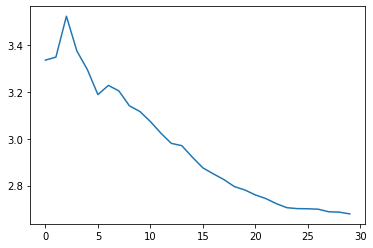

In [62]:
plt.plot(xs,[y.item() for y in ys])

(array([917., 460., 295., 204., 134.,  78.,  59.,  44.,  37.,  21.,  17.,
         17.,   7.,  11.,   5.,   5.,   7.,   3.,   5.,   1.,   2.,   1.,
          2.,   1.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

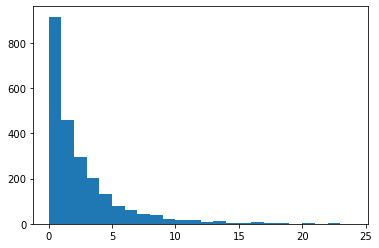

In [ ]:
torch.save(neural.state_dict(), "trained.pth")